In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
from tqdm import trange, tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read the classified events

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [6]:
basic_filtering = \
    (~pl.col("has_common_transition")) & \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10)

In [7]:
trusty_cls_df = (cls_df
    .filter(basic_filtering)
)

very_trusty_cls_df = trusty_cls_df.filter(extra_filtering)

# Utils

In [8]:
def hist_transitions(df, upto=2):
    return np.histogram(df["n_transitions"], bins=np.arange(upto+2), density=True)[0]

# Functions to get call set for a subset of samples

In [9]:
def generate_call_set(focal_sample_ids, take_every=1, bootstrap=False, cutoff=None, min_snps=0):
    certainty = "0.95"
    
    # Get all the other reads
    all_sampled_reads = []

    for focal_sample_id in focal_sample_ids:
        for t2t_chrom in aut_chrom_names:
            denovo_chrom = t2t_chrom + "_RagTag"

            patterns_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_{certainty}.candidate_reads.patterns.parquet"

            pat_df = pl.scan_parquet(patterns_filename)
            pat_df = pat_df.gather_every(take_every)

            all_sampled_reads.append(pat_df)

    all_sampled_reads = pl.concat(all_sampled_reads).collect(streaming=True)
    
    # Create the joint dataframe
    both_df = (
        pl.concat([
            (trusty_cls_df
                .filter(pl.col("class") != "CNCO")
                .filter(pl.col("sample_id").is_in(focal_sample_ids))
                .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                .with_columns(weight = 1)
            ), 
            (all_sampled_reads
                .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                .with_columns(weight = take_every)
            )
        ])
    )   
    
    # Make sure we have minimal number of SNPs
    both_df = both_df.filter(pl.col("snp_positions_on_read").list.len() >= min_snps)
    
    # Cutoff if needed
    if cutoff:
        both_df = both_df.filter(
            pl.when(pl.col("idx_transitions").list.len() != 2).then(pl.lit(True)).otherwise(
                (pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) - \
                 pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))) < cutoff
            )
        )
    
    # Bootstrap if needed
    if bootstrap:
        both_df = both_df.sample(n = len(both_df), with_replacement = True)
    
    # Add useful fields
    aug_both_df = (both_df
        .with_columns(
            prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
            n_transitions = pl.col("idx_transitions").list.len(),
        )
        .with_columns(
            rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
        )
    )
    
    return aug_both_df


# Extract meaningful statistics from readset

In [10]:
def extract_n_transitions_dist(df):
    return np.histogram(df.select(pl.col("idx_transitions").list.len()), bins=np.arange(0, 4))[0]

def extract_n_snps_dist(df):
    n_snps = (df
        .filter(pl.col("idx_transitions").list.len() == 2)
        .select(
            pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)
        )
    )
    
    return np.histogram(n_snps, bins=np.arange(0, 10))[0]

def extract_tract_upper_bound_list(df):
    tract_upper_bound = (df
        .filter(pl.col("idx_transitions").list.len() == 2)
            .select(
                pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("first_transition_snp"),
                pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1).alias("last_transition_snp"),
            )
            .select((pl.col("last_transition_snp") - pl.col("first_transition_snp")).alias("tract_upper_bound"))
    )
    
    return tract_upper_bound["tract_upper_bound"].to_numpy()

def extract_tract_lower_bound_list(df):
    tract_lower_bound = (df
        .filter(pl.col("idx_transitions").list.len() == 2)
            .select(
                pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1).alias("first_transition_snp"),
                pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)).alias("last_transition_snp"),
            )
            .select((pl.col("last_transition_snp") - pl.col("first_transition_snp")).alias("tract_lower_bound"))
    )
    
    return tract_lower_bound["tract_lower_bound"].to_numpy()

In [11]:
def extract_all_summary_stats(df):
    res = {
        "n_transitions": extract_n_transitions_dist(df),
        "n_snps": extract_n_snps_dist(df),
        "tract_upper_bound": extract_tract_upper_bound_list(df),
        "tract_lower_bound": extract_tract_lower_bound_list(df),
    }
    
    return res

# Get all reads, except complex (about 27GB)

In [12]:
%%time
all_df = generate_call_set(sample_ids)

CPU times: user 1min 8s, sys: 21.9 s, total: 1min 30s
Wall time: 59.6 s


In [13]:
stats = extract_all_summary_stats(all_df)

# Simulate

In [14]:
def simulate_and_stats(
    all_df,
    prob_CO,
    prob_GC_component,
    GC_tract_mean,
    GC_tract_mean2,
    recombination_rate_per_bp,
):
    subset_idx_transitions_array, subset_snp_positions_on_read_array, n_noevents = inference.simulate_many_read_patterns(
        all_df["read_length"], 
        all_df["snp_positions_on_read"], 
        prob_CO,
        prob_GC_component,
        GC_tract_mean,
        GC_tract_mean2,
        recombination_rate_per_bp,
        42,
    )
    
    sim_df = pl.from_pandas(pd.DataFrame({
        "idx_transitions": subset_idx_transitions_array, 
        "snp_positions_on_read": subset_snp_positions_on_read_array,
    }))

    # Get stats
    stats = extract_all_summary_stats(sim_df)
    
    # Add artificially the number of non-events
    stats["n_transitions"][0] += n_noevents

    return stats

In [15]:
simulate_and_stats(
    all_df,
    prob_CO = 0.12,
    prob_GC_component = 0.993,
    GC_tract_mean = 30,
    GC_tract_mean2 = 1100,
    recombination_rate_per_bp = 1e-7,
)

{'n_transitions': array([31963620,     3646,      839]),
 'n_snps': array([  0, 764,  51,  11,   5,   4,   1,   1,   1]),
 'tract_upper_bound': array([ 7609,   344,  3240,   500,  2396,   985,  1066,  2358,  3401,
          605,   360,   694,  1400,  1098,  2102,   257,  1826,   658,
          987,  1005,  1011,  1054,  2812,  1173,   751,  1179,   666,
          632,   752,   303,  2317,  1110,   946,  1128,   936,   958,
         1018,  1655,   840,  1588,   355,  1070,   900,  1739,  3676,
         1856,   453,  1038,  1345,   247,   962,  1765,  2510,  1392,
         1442,  5243,  1284,   196,  1019,  1574,  2269,   144,  1265,
          892,  2427,   371,   249,   110,  3181,  6877,  1250,  1032,
         1656,   554,  1731,  2615,   989,   906,   598,   380,   869,
          973,   861,  1635,  1506,   128,   725,   264,   776,   508,
          171,  2029,   142,  2560,   172,  2297,  1294,   395,  1212,
         8316,  2496,  1878,   129,   473,   622,   378,   639,  2458,
     

In [16]:
np.array([2752501,   12689,   42279]) / np.array([2752501,   12689,   42279]).sum()

array([0.9804208 , 0.00451973, 0.01505947])

In [17]:
(1-9.99970436e-01)*100

0.002956399999998194

In [30]:
%%time
all_tract_lengths = np.arange(10, 110, 10)
all_tract_stats = {tt: simulate_and_stats(all_df, 0.12, 1, tt, 666, 1e-7) for tt in tqdm(all_tract_lengths)}



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

 20%|██        | 2/10 [00:02<00:09,  1.19s/it]

  0%|          | 0/10 [00:23<?, ?it/s].19s/it]


 40%|████      | 4/10 [00:04<00:07,  1.26s/it]

 50%|█████     | 5/10 [00:06<00:06,  1.23s/it]

 60%|██████    | 6/10 [00:07<00:04,  1.22s/it]

 70%|███████   | 7/10 [00:08<00:03,  1.27s/it]

 80%|████████  | 8/10 [00:09<00:02,  1.25s/it]

 90%|█████████ | 9/10 [00:11<00:01,  1.23s/it]

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

CPU times: user 11.3 s, sys: 1.2 s, total: 12.5 s
Wall time: 12.5 s


In [31]:
print(f"Real:\t {stats['n_transitions']} \t {stats['n_snps']}")
print()
for tt in all_tract_lengths:
    print(f"{tt}:\t {all_tract_stats[tt]['n_transitions']} \t {all_tract_stats[tt]['n_snps']}")

Real:	 [28071714     2490      491] 	 [  0 447  31   8   3   2   0   0   0]

10:	 [28072093     2425      177] 	 [  0 176   1   0   0   0   0   0   0]
20:	 [28071880     2465      350] 	 [  0 341   9   0   0   0   0   0   0]
30:	 [28071660     2518      517] 	 [  0 493  24   0   0   0   0   0   0]
40:	 [28071465     2562      668] 	 [  0 624  43   1   0   0   0   0   0]
50:	 [28071270     2599      826] 	 [  0 769  56   1   0   0   0   0   0]
60:	 [28071082     2642      971] 	 [  0 895  73   3   0   0   0   0   0]
70:	 [28070918     2682     1095] 	 [  0 994  95   6   0   0   0   0   0]
80:	 [28070733     2719     1243] 	 [   0 1112  122    9    0    0    0    0    0]
90:	 [28070546     2762     1387] 	 [   0 1226  144   16    1    0    0    0    0]
100:	 [28070358     2810     1527] 	 [   0 1327  175   23    2    0    0    0    0]


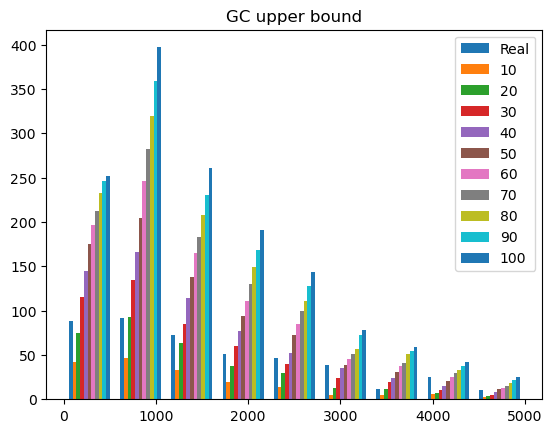

In [32]:
plt.title("GC upper bound");
plt.hist(
    [stats["tract_upper_bound"]] + \
    [all_tract_stats[tt]["tract_upper_bound"] for tt in all_tract_lengths],
    bins=np.linspace(0,5000,10),
);
plt.legend(["Real"] + [str(tt) for tt in all_tract_lengths]);

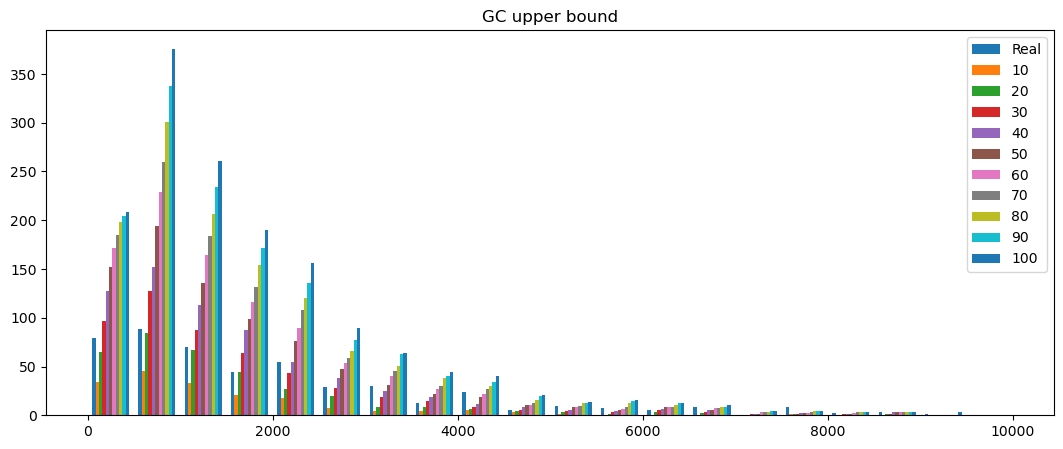

In [33]:
plt.figure(figsize=(13,5));
plt.title("GC upper bound");
plt.hist(
    [stats["tract_upper_bound"]] + \
    [all_tract_stats[tt]["tract_upper_bound"] for tt in all_tract_lengths],
    bins=np.linspace(0,10000,21),
    log=False,
);
plt.legend(["Real"] + [str(tt) for tt in all_tract_lengths]);

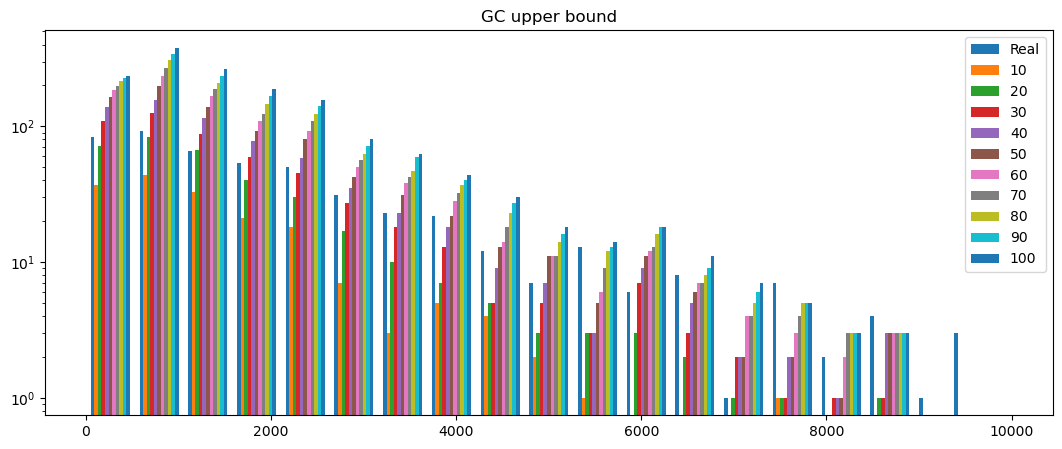

In [34]:
plt.figure(figsize=(13,5));
plt.title("GC upper bound");
plt.hist(
    [stats["tract_upper_bound"]] + \
    [all_tract_stats[tt]["tract_upper_bound"] for tt in all_tract_lengths],
    bins=np.linspace(0,10000,20),
    log=True,
);
plt.legend(["Real"] + [str(tt) for tt in all_tract_lengths]);

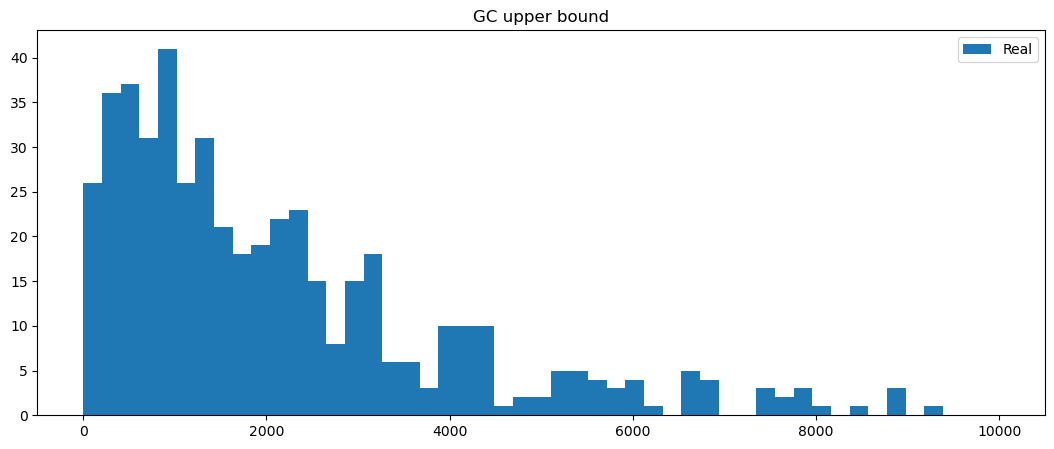

In [35]:
plt.figure(figsize=(13,5));
plt.title("GC upper bound");
plt.hist(
    [stats["tract_upper_bound"]],
    bins=np.linspace(0,10000,50),
    log=False,
);
plt.legend(["Real"] + [str(tt) for tt in all_tract_lengths]);

# Try to fit manually

In [22]:
# 1.20680158e-01,  9.82364721e-01,  2.56176693e+01,  2.25231434e+02, -7.00000000e+00

sim_stats = simulate_and_stats(
    all_df,
    prob_CO = 0.12,
    prob_GC_component = 0.98,
    GC_tract_mean = 30,
    GC_tract_mean2 = 100,
    recombination_rate_per_bp = 1e-7,
)

Real:	 [31954000     9538     4184]
Sim:	 [31963671     3624      810]

Real:	 [   0 3728  175   49   14    8    5    1    0]
Sim:	 [  0 766  42   1   1   0   0   0   0]



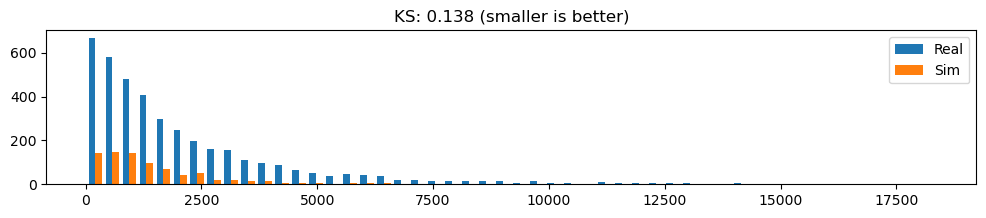

In [23]:
print("Real:\t", stats["n_transitions"])
print("Sim:\t", sim_stats["n_transitions"])
print()
print("Real:\t", stats["n_snps"])
print("Sim:\t", sim_stats["n_snps"])
print()
plt.figure(figsize=(12,2))
plt.hist(
    [stats["tract_upper_bound"], sim_stats["tract_upper_bound"]],
    bins=50,
);
ks_stat = scipy.stats.ks_2samp(stats["tract_upper_bound"], sim_stats["tract_upper_bound"]).statistic
plt.title(f"KS: {ks_stat:.3f} (smaller is better)");
plt.legend(["Real", "Sim"]);

# Simulate conditional on min SNPs

## With tract length 50

In [36]:
%%time
all_min_snps = np.arange(2, 11)
all_min_snps_stats = {m: simulate_and_stats(
        all_df.filter(pl.col("snp_positions_on_read").list.len() >= m), 
        0.12,
        1,
        50,
        666,
        1e-7
    ) \
    for m in tqdm(all_min_snps)}


100%|██████████| 9/9 [00:34<00:00,  3.81s/it]

CPU times: user 20.6 s, sys: 21.5 s, total: 42 s
Wall time: 34.3 s


In [37]:
for m in all_min_snps:
    stats_m = extract_all_summary_stats(all_df.filter(pl.col("snp_positions_on_read").list.len() >= m))
    print(f"Min SNPs: {m}")
    print(f"Real:\t {stats_m['n_transitions']} \t {stats_m['n_snps']}")
    print(f"Sim:\t {all_min_snps_stats[m]['n_transitions']} \t {all_min_snps_stats[m]['n_snps']}")
    print

Min SNPs: 2
Real:	 [23423118     2490      491] 	 [  0 447  31   8   3   2   0   0   0]
Sim:	 [23422590     2664      845] 	 [  0 797  40   7   1   0   0   0   0]
Min SNPs: 3
Real:	 [20771217     2219      491] 	 [  0 447  31   8   3   2   0   0   0]
Sim:	 [20770733     2413      781] 	 [  0 721  57   3   0   0   0   0   0]
Min SNPs: 4
Real:	 [18846640     2039      471] 	 [  0 427  31   8   3   2   0   0   0]
Sim:	 [18846023     2296      831] 	 [  0 777  50   3   1   0   0   0   0]
Min SNPs: 5
Real:	 [17171961     1876      449] 	 [  0 406  30   8   3   2   0   0   0]
Sim:	 [17171335     2153      798] 	 [  0 755  42   1   0   0   0   0   0]
Min SNPs: 6
Real:	 [15606305     1728      423] 	 [  0 381  29   8   3   2   0   0   0]
Sim:	 [15605669     1992      795] 	 [  0 738  51   6   0   0   0   0   0]
Min SNPs: 7
Real:	 [14123892     1572      391] 	 [  0 356  26   7   0   2   0   0   0]
Sim:	 [14123185     1907      763] 	 [  0 700  58   3   2   0   0   0   0]
Min SNPs: 8
Real:	 [12

# Do some ABC-style optimization

In [111]:
import scipy.stats

def ABC(
    df,
    prob_CO_range,
    prob_GC_component_range,
    GC_tract_mean_range,
    GC_tract_mean2_range,
    recombination_rate_per_bp_range,
    basinhopping_iters = 50,
    x0 = None,
):    
    def compare_stats(original_stats, current_stats):
        # n transitions
        # S1 = scipy.stats.chi2_contingency(
        #     [original_stats["n_transitions"], current_stats["n_transitions"]]
        # ).statistic
        S1 = np.linalg.norm(
            original_stats["n_transitions"] - current_stats["n_transitions"]
        )       
        
        
        # n snps
        # T = np.array([original_stats["n_snps"], current_stats["n_snps"]])
        # T = T[:, T.sum(axis=0)>0]
        # S = scipy.stats.chi2_contingency(T).statistic
        S2 = np.linalg.norm(
            original_stats["n_snps"] - current_stats["n_snps"]
        )       
        
        S3 = scipy.stats.ks_2samp(original_stats["tract_upper_bound"], current_stats["tract_upper_bound"]).statistic
        
        S = S1 + S2 + S3 * 10

        return S


    def minimizeme(x, df, original_stats):
        current_stats = simulate_and_stats(
            df,
            x[0],
            x[1],
            x[2],
            x[3],
            10**x[4],
        )

        S = compare_stats(original_stats, current_stats)

        with np.printoptions(precision=3, suppress=True):
            print(x, S)
            
        return S

        
    original_stats = extract_all_summary_stats(df)

    bounds = [prob_CO_range, prob_GC_component_range, GC_tract_mean_range, GC_tract_mean2_range, recombination_rate_per_bp_range]
    lower_bounds = np.array([x[0] for x in bounds])
    upper_bounds = np.array([x[1] for x in bounds])
    stepsize = np.diff(np.array(bounds), axis=1).ravel() / 20
    
    if x0 is None:
        x0 = [
            np.mean(prob_CO_range), 
            np.mean(prob_GC_component_range), 
            np.mean(GC_tract_mean_range), 
            np.mean(GC_tract_mean2_range), 
            np.mean(recombination_rate_per_bp_range)
        ]
#     resbrute = scipy.optimize.brute(
#         func = minimizeme, 
#         ranges = bounds, 
#         args=(df, original_stats), 
#         Ns=4, 
#         full_output=0, 
#         finish=None, 
#         disp=False, 
#         workers=1,
#     )
    
#     return resbrute
    
    def take_step(x):
        min_step = np.maximum(lower_bounds - x, -stepsize)
        max_step = np.minimum(upper_bounds - x, stepsize)

        random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        xnew = x + random_step
        
        return xnew
    
    res = scipy.optimize.basinhopping(
        func = minimizeme,
        x0 = x0,      
        take_step=take_step,
        minimizer_kwargs={
            "method": "Nelder-Mead", 
            "bounds": bounds,
            "options": {"maxiter": 10000, "xatol": 1e-3},            
            "args": (df, original_stats),
        },
        niter=basinhopping_iters,
        niter_success=5,
        disp=True,
    )
    
    # res = scipy.optimize.minimize(
    #     fun = minimizeme,
    #     x0 = [np.mean(prob_CO_range), np.mean(GC_tract_mean_range), np.mean(recombination_rate_per_bp_range)],
    #     method = "Nelder-Mead",
    #     args = (df, original_stats),
    #     bounds = [prob_CO_range, GC_tract_mean_range, recombination_rate_per_bp_range],
    #     options={'xatol': 1e-3},
    # )
    
    return res


## Fit # transitions, fix prob and rate

In [ ]:
res = ABC(
    all_df,
    [0.1, 0.15],
    [0.95, 1],
    [0, 1000],
    [0, 1000],
    [-7,-7],
    x0 = [0.12, 0.96, 30, 200, -7],
)

In [135]:
res.x

array([ 1.20664753e-01,  9.99919043e-01,  2.89616852e+01,  4.14100626e+02,
       -7.00000000e+00])

Real:	 [28071714     2490      491]
Sim:	 [28071679     2526      490]

Real:	 [  0 447  31   8   3   2   0   0   0]
Sim:	 [  0 441  34   9   1   3   1   1   0]



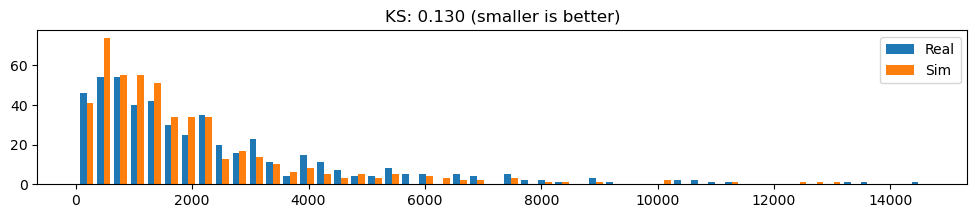

In [60]:
# BEST: array([ 1.20680158e-01,  9.82364721e-01,  2.56176693e+01,  2.25231434e+02, -7])
# BEST2: array([ 1.20664753e-01,  9.99919043e-01,  2.89616852e+01,  4.14100626e+02, -7.00000000e+00])
## ll_sol = np.array([0.12,  0.993, 30, 1100, 10**-7])

sim_stats = simulate_and_stats(all_df, 0.12,  0.993, 26, 1100, 10**-7)

print("Real:\t", stats["n_transitions"])
print("Sim:\t", sim_stats["n_transitions"])
print()
print("Real:\t", stats["n_snps"])
print("Sim:\t", sim_stats["n_snps"])
print()
plt.figure(figsize=(12,2))
plt.hist(
    [stats["tract_upper_bound"], sim_stats["tract_upper_bound"]],
    bins=50,
);
ks_stat = scipy.stats.ks_2samp(stats["tract_upper_bound"], sim_stats["tract_upper_bound"]).statistic
plt.title(f"KS: {ks_stat:.3f} (smaller is better)");
plt.legend(["Real", "Sim"]);

## Fit # transitions, fit prob and fix rate

In [154]:
res = ABC(
    all_df,
    [0, 1],
    [1, 1000],
    [1e-7, 1e-7],
)

[5.000e-01 5.005e+02 1.000e-07] 1396.2378020953308
[5.250e-01 5.005e+02 1.000e-07] 1289.236595819402
[5.00000e-01 5.25525e+02 1.00000e-07] 1419.8827416374918
[5.000e-01 5.005e+02 1.000e-07] 1396.2378020953308
[5.16666667e-01 4.75475000e+02 1.00000000e-07] 1278.7939630761477
[5.2500e-01 4.5045e+02 1.0000e-07] 1249.761977338085
[5.33333333e-01 4.67133333e+02 1.00000000e-07] 1176.3434872519165
[5.5000e-01 4.5045e+02 1.0000e-07] 1147.12466628523
[5.66666667e-01 4.33766667e+02 1.00000000e-07] 1048.2380454839445
[6.000e-01 4.004e+02 1.000e-07] 907.6133538021573
[5.91666667e-01 3.67033333e+02 1.00000000e-07] 806.6715564590089
[6.250e-01 3.003e+02 1.000e-07] 722.3614053920655
[6.58333333e-01 3.16983333e+02 1.00000000e-07] 579.3099343184095
[7.2500e-01 2.5025e+02 1.0000e-07] 323.156308928048
[7.50000000e-01 1.83516667e+02 1.00000000e-07] 182.31017525086196
[8.500e-01 5.005e+01 1.000e-07] 305.8153037374029
[8.00000000e-01 8.89777778e+01 1.00000000e-07] 160.1030917877603
[9.e-01 1.e+00 1.e-07] 44

In [155]:
print(res.x)
print("Real:\t", stats["n_transitions"], "\t", stats["n_snps"])
print("Best:\t", simulate_and_stats(all_df, *res.x)["n_transitions"], "\t", simulate_and_stats(all_df, *res.x)["n_snps"])

[7.15028976e-01 1.03912217e+02 1.00000000e-07]
Real:	 [28071714     2490      491] 	 [  0 447  31   8   3   2   0   0   0]
Best:	 [28060400    13803      492] 	 [  0 445  33  11   2   0   1   0   0]


150.023548

## Fit # transitions, fit prob and fit rate

In [157]:
res = ABC(
    all_df,
    [0, 1],
    [1, 1000],
    [-8,-6],
)

[ 5.000e-01  5.005e+02 -7.000e+00] 1396.2378020953308
[  0.525 500.5    -7.   ] 1289.236595819402
[ 5.00000e-01  5.25525e+02 -7.00000e+00] 1419.8827416374918
[ 5.000e-01  5.005e+02 -7.350e+00] 424.6928301725849
[  0.51666667 475.475       -7.23333333] 576.9670701175241
[  0.52777778 483.81666667  -7.38888889] 321.6069029109916
[  0.54166667 475.475       -7.58333333] 124.28193754524428
[  0.51388889 467.13333333  -7.77777778] 188.43035848822237
[  0.52037037 486.59722222  -7.90740741] 234.06409378629607
[  0.55061728 452.3037037   -8.        ] 283.56128085477394
[  0.53796296 464.35277778  -7.95925926] 278.53904573685895
[  0.51265432 488.45092593  -7.55308642] 121.66757990524839
[ 5.000e-01  5.005e+02 -7.350e+00] 424.6928301725849
[  0.52510288 467.44228395  -7.36872428] 270.07961789072493
[  0.5215535  481.80848765  -7.77273663] 198.9949748109233
[  0.52391975 472.23101852  -7.50339506] 156.3361762357005
[  0.5382716  490.30462963  -7.3154321 ] 392.10967853395306
[  0.51998457 472.92

Real:	 [28071714     2490      491] 	 [  0 447  31   8   3   2   0   0   0]
Best:	 [28071584     2549      562] 	 [  0 510  37   9   1   3   1   1   0]
